In [2]:
import dowhy
from dowhy import CausalModel
from dowhy.causal_refuters.placebo_treatment_refuter import PlaceboType
import dowhy.causal_refuters.bootstrap_refuter
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:
dowhy.__version__ # v0.12

'0.12'

In [4]:
# Digraph Syntax

causal_graph = """
digraph {
geneA -> smoking; geneA -> lung_cancer;
geneB -> geneA; geneB -> smoking;
geneC -> geneA; geneC -> lung_cancer;
smoking -> lung_cancer;
}
"""

In [5]:
df_model = pd.DataFrame(columns=['geneA', 'geneB', 'geneC', 'smoking', 'lung_cancer'])
df_model.head()

,geneA,geneB,geneC,smoking,lung_cancer


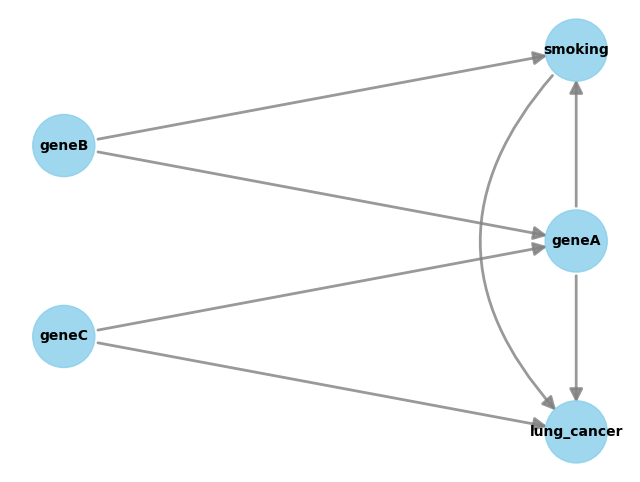

In [6]:
# Define a CausalModel object in DoWhy, indicate treatment & outcome
model= CausalModel(data=df_model, # data columns
        graph=causal_graph, # DAG
        treatment='smoking', # cause of interest, X
        outcome='lung_cancer') # outcome, Y
model.view_model()

In [7]:
# https://www.pywhy.org/dowhy/v0.12/user_guide/causal_tasks/estimating_causal_effects/identifying_causal_effect/backdoor.html

estimands = model.identify_effect(method_name='minimal-adjustment', proceed_when_unidentifiable=True)
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                 
──────────(E[lung_cancer|geneC,geneA])
d[smoking]                            
Estimand assumption 1, Unconfoundedness: If U→{smoking} and U→lung_cancer then P(lung_cancer|smoking,geneC,geneA,U) = P(lung_cancer|smoking,geneC,geneA)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
# Function to simulate data with continuous treatment and multiple outcomes
def simulate_data_continuous_multiple_outcomes(sample_size=100000):
    np.random.seed(2)
    
    # GeneA confounder / collider on a different path
    geneA = np.random.normal(0, 1, sample_size)
    # GeneB
    geneB = np.random.normal(0, 1, sample_size)
    # GeneC
    geneC = geneB + np.random.normal(0, 1, sample_size)

    # collider on this path
    geneA = 4 * geneB + 1.6 * geneC + np.random.normal(0, 1, sample_size)
    
    # Continuous treatment influenced by confounder
    smoking = 0.5 * geneA + 0.3 * geneB + np.random.normal(0, 1, sample_size)

    # Multiple outcomes influenced by treatment and confounder
    lung_cancer = 2 * smoking + 3 * geneA + 0.75 * geneC + np.random.normal(0, 1, sample_size)
        
    data = pd.DataFrame({
        'smoking': smoking, 
        'lung_cancer': lung_cancer, 
        'geneA': geneA,
        'geneB': geneB,
        'geneC': geneC,
    })
    return data

# Create data
data = simulate_data_continuous_multiple_outcomes()

# Display the first few rows of the data
print(data.head())

    smoking  lung_cancer     geneA     geneB     geneC
0  1.611672    -1.238570 -1.019180 -0.287606 -0.261171
1 -3.839105   -25.772262 -6.014744 -1.325834 -0.833924
2 -3.291666   -17.351881 -4.135709 -0.967689  0.294185
3  4.639568    39.370615  9.184113  1.659351  1.802073
4 -1.281593    -9.270312 -1.851391 -0.287069 -0.812321


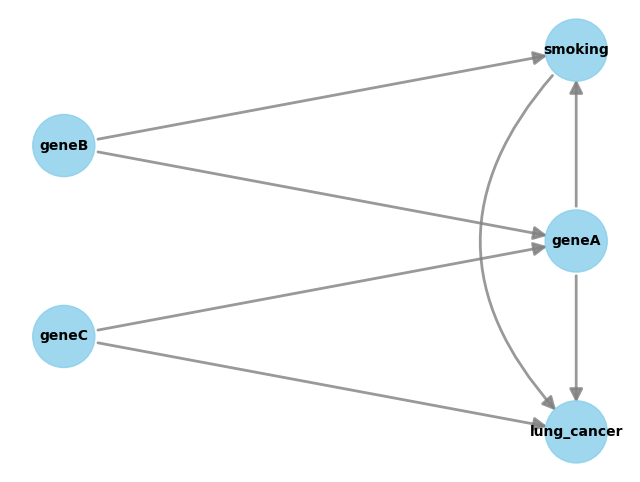

In [9]:
# Define a CausalModel object in DoWhy, indicate treatment & outcome
model= CausalModel(
    data=data, # data columns
    graph=causal_graph,
    treatment='smoking', # cause of interest, X
    outcome='lung_cancer', # outcome, Y
    #common_causes=['geneA', 'geneB']
    )
model.view_model()

In [10]:
# Identify causal effect
identified_estimand = model.identify_effect(method_name='minimal-adjustment', proceed_when_unidentifiable=True)

In [11]:
# Estimate causal effect using linear regression
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

# Print results
print(estimate)
estimate.interpret()

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                 
──────────(E[lung_cancer|geneC,geneA])
d[smoking]                            
Estimand assumption 1, Unconfoundedness: If U→{smoking} and U→lung_cancer then P(lung_cancer|smoking,geneC,geneA,U) = P(lung_cancer|smoking,geneC,geneA)

## Realized estimand
b: lung_cancer~smoking+geneC+geneA
Target units: ate

## Estimate
Mean value: 2.000807071764444

Increasing the treatment variable(s) [smoking] from 0 to 1 causes an increase of 2.000807071764444 in the expected value of the outcome [['lung_cancer']], over the data distribution/population represented by the dataset.


In [12]:
print("Backdoor variables:")
for b in sorted(identified_estimand.get_backdoor_variables()):
    print(b)

Backdoor variables:
geneA
geneC


In [13]:
# Refute the estimate - Placebo Treatment
# What happens to the estimated causal effect when we replace the true treatment variable with an independent permutated treatment variable?
# If our assumptions were correct then this newly found estimate should go to 0.
refutation = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="placebo_treatment_refuter", 
    random_seed=13, 
    placebo_type = dowhy.causal_refuters.placebo_treatment_refuter.PlaceboType.PERMUTE
    )
print(refutation)

# Null hypothesis is that the placebo treatment has an effect on the outcome.
# p_value = 1.0 indicating that the null hypothesis can be rejected. Placebo treatment effect is statistically insignificant, suggesting that the model behaves as expected when the treatment is replaced with a placebo.

Refute: Use a Placebo Treatment
Estimated effect:2.000807071764444
New effect:0.00016052597616338096
p value:1.0



In [14]:
# Refute the estimate - Random Common Cause
# Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset?
# If our assumption was originally correct then the causal estimate shouldn't change by much.
refutation = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="random_common_cause",
    random_seed=13
    )
print(refutation)

# Null hypothesis is that the effect size is significantly different after adding the random common cause.
# p_value = 0.94 indicating the the null hypotheis can be rejected. The new effect is statistically indistinguishable from the original effect.

Refute: Add a random common cause
Estimated effect:2.000807071764444
New effect:2.0008081105153575
p value:0.94



In [15]:
# Refute the estimate - Data subsample
# Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset?
# If our assumption was originally correct then the causal estimate shouldn't change by much.
refutation = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="data_subset_refuter",
    random_seed=13
    )
print(refutation)

# Null hypothesis is that the new effect size (from the subset) is significantly different from the original effect size (from the full dataset).
# p_value = 0.89 indicating that the null hypothesis can be rejected. The difference between the original and subset-based effect estimates is not statistically significant.

Refute: Use a subset of data
Estimated effect:2.000807071764444
New effect:2.0010894328929
p value:0.8999999999999999



In [16]:
# Refute the estimate - Bootstrap
# Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset?
# If our assumption was originally correct then the causal estimate shouldn't change by much.
refutation = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="bootstrap_refuter", 
    required_variables=False,
    random_seed=13
    )
print(refutation)

# Null hypothesis that there is a significant difference between the original treatment effect and the new effect from bootstrap sampling.
# p_value = 0.86 indicating that the null hypothesis can be rejected. This confirms that The difference between the original and bootstrap-based effect is not statistically significant.

Refute: Bootstrap Sample Dataset
Estimated effect:2.000807071764444
New effect:2.000186248368124
p value:0.86

